In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from keras.datasets import cifar10


Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 33s 0us/step


In [0]:
x_train, x_test = x_train / 255.0, x_test / 255.0

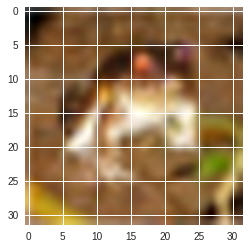

In [4]:
plt.imshow(x_train[0], interpolation='spline16')

In [0]:
from keras import backend as K
from keras.callbacks import Callback
import matplotlib.pyplot as plt

class LRFinder(Callback):
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
        
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        
    def _moving_average(self, arr, n):
        ret = np.cumsum(arr, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n
        
    def plot_loss(self, smooth=1):
        '''Helper function to quickly observe the learning rate experiment results.'''
        x, y = self._moving_average(self.history['lr'], n=smooth), \
               self._moving_average(self.history['loss'], n=smooth)
        plt.plot(x, y)
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def get_model():
    model = Sequential([
        Conv2D(filters=64, kernel_size=[5,5], input_shape=x_train.shape[1:], strides=[1, 1], activation='relu'),
        MaxPooling2D(pool_size=[3, 3], strides=[2, 2]),

        Conv2D(filters=64, kernel_size=[5,5], strides=[1, 1], activation='relu'),
        MaxPooling2D(pool_size=[3, 3], strides=[2, 2]),

        Flatten(),

        Dense(384, activation='relu'),
        Dense(192, activation='relu'),
        Dense(10, activation='softmax')
      ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


model = get_model()

In [17]:
batch_size = 32
epochs = 4 

lr_finder = LRFinder(min_lr=1e-5,
                     max_lr=1e-2,
                     steps_per_epoch=np.ceil(x_train.shape[0]/batch_size), 
                     epochs=epochs)

model.fit(x_train, y_train, 
          epochs=epochs, batch_size=batch_size,
          callbacks=[lr_finder])

Epoch 1/4
50000/50000 [==============================] - 22s 449us/step - loss: 1.6116 - acc: 0.4131
Epoch 2/4
50000/50000 [==============================] - 22s 442us/step - loss: 1.3888 - acc: 0.5100
Epoch 3/4
50000/50000 [==============================] - 22s 443us/step - loss: 1.4741 - acc: 0.4897
Epoch 4/4
50000/50000 [==============================] - 22s 445us/step - loss: 1.5836 - acc: 0.4528


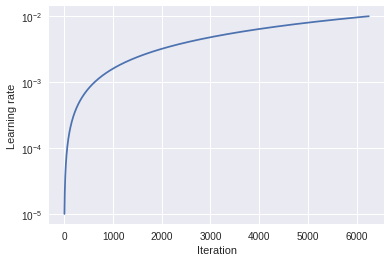

In [18]:
lr_finder.plot_lr()


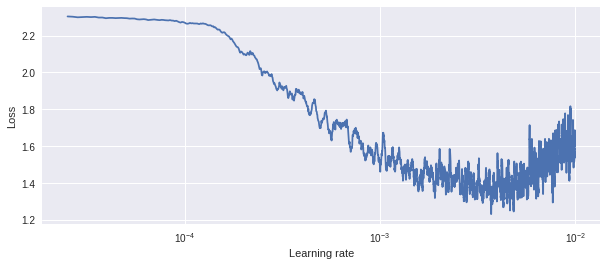

In [44]:
plt.figure(figsize=(10, 4))
lr_finder.plot_loss(smooth=20)


In [47]:
iteration = 180
print('Loss:', lr_finder.history['loss'][iteration])
print('Learning rate:', lr_finder.history['lr'][iteration])


Loss: 1.8415127
Learning rate: 0.00029761996


In [48]:
from keras.optimizers import Adam

model = get_model()
model.optimizer=Adam(lr=3e-4)

model.fit(x_train, y_train, 
          epochs=10, batch_size=batch_size,
          validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 21s 418us/step - loss: 1.5424 - acc: 0.4348 - val_loss: 1.3594 - val_acc: 0.5205
Epoch 2/10
50000/50000 [==============================] - 21s 411us/step - loss: 1.1973 - acc: 0.5751 - val_loss: 1.1212 - val_acc: 0.6007
Epoch 3/10
50000/50000 [==============================] - 21s 418us/step - loss: 1.0397 - acc: 0.6304 - val_loss: 1.0475 - val_acc: 0.6361
Epoch 4/10
50000/50000 [==============================] - 21s 418us/step - loss: 0.9378 - acc: 0.6712 - val_loss: 1.0825 - val_acc: 0.6230
Epoch 5/10
50000/50000 [==============================] - 21s 416us/step - loss: 0.8542 - acc: 0.6975 - val_loss: 0.9932 - val_acc: 0.6629
Epoch 6/10
50000/50000 [==============================] - 21s 416us/step - loss: 0.7837 - acc: 0.7223 - val_loss: 0.9879 - val_acc: 0.6609
Epoch 7/10
50000/50000 [==============================] - 21s 418us/step - loss: 0.7231 - acc: 0.7463 - val_loss: 0.